==============================================================================================
# Practicum 6 - Part 2

==============================================================================================

## Delivery

Up to **1 point out of 10** will be penalized if the following requirements are not fulfilled:

- Implemented code should be commented.

- The questions introduced in the exercises must be answered.

- Add title to the figures to explain what is displayed.

- Comments need to be in **english**.

- The deliverable must be a file named **P6_Student1_Student2.zip** that includes:
    - The notebook P6_2_Student1_Student2.ipynb completed with the solutions to the exercises and their corresponding comments.
    - All the images used in this notebook.

**Deadline (Group A- Group F): December 23th, 23:00 h**

**Deadline (Group B): December 24th, 23:00 h**

==============================================================================================
## Dimensionality reduction and face detection
==============================================================================================

**Problem to solve**: Define a space of image feature that allows to represent objects based on their appearance or a set of local features in the image.

Documentation [Face recognition skimage](https://scikit-learn.org/stable/auto_examples/applications/plot_face_recognition.html)

==============================================================================================


Today's exercices will practise the following:

1. Define an appropiate representation (descriptors objects):
    - Normally, reduce size of the data preserving the invariance and removing redundant dimensions.


2. Train a classifier from a set of examples with their descriptors.


3. Recognize a new face example using the learned model.

## Imports

In [88]:
from time import time
import timeit

import numpy as np
from numpy import unique
import matplotlib.pyplot as plt

In [89]:
def visualize_n(image_list):

    fig=plt.figure(figsize=(15,15))
    for i in range(len(image_list)):
        
        fig.add_subplot(1,len(image_list),i +1)
        plt.imshow(image_list[i], cmap='gray')
        plt.xticks([])
        plt.yticks([])
        
def visualize_n_w_labels(image_list, labels):

    fig=plt.figure(figsize=(15,15))
    for i in range(len(image_list)):
        
        fig.add_subplot(1,len(image_list),i +1)
        plt.imshow(image_list[i], cmap='gray')
        plt.title(labels[i])
        plt.xticks([])
        plt.yticks([])
        


## Principal Component Analysis (PCA)

### Dimensionality and redundancy

Imagine we have a dataset with 100x100 pixel images, it means we have 10000 dimensions. We want to construct a low-dimensional linear subspace that best explains the variation in the set of face images (**Eigenfaces space**)

<img src="notebook_images/subspace.PNG" width=200, height=200>

Each image has m rows and n columns and defines a vector of (mxn) elements. We need to choose the most valuable pixels in order to avoid compute all dimensions. 

<img src="notebook_images/feature_vector.PNG" width=800, height=400>

We look for a transformation of the original space to a smaller (M << (mxn)) where faces are represented with their coordinates in this new space R.

To reduce the dimensionality retaining the information necessary to classify and recognize, we are going to use the **Eigenfaces method** 

### How to build a reduced space?

To build this new space, we are going to use the **Principal Component Analysis**. Given a large space, the PCA looks for the minimum number of axes that best represents the variation of the data.

<img src="notebook_images/pca.PNG" width=400, height=400>

The eigenvectors of the covariance matrix define the axis of maximum variance and the eigenvalues give a measure of the variance of the data. 

1. Construct the vector in the (m x n)-dimensional space R given M images of size (m x n).

2. Compute the mean image 

<center>
$\overline{X}=\frac{1}{M}\sum_{i=1}^{M} X_i$
</center>

3. Construct the covariance matrix. Due to $A \times A^T$ is too large, instead of using $A \times A^T$ to compute its eigenvectors, we are going to compute the eigenvectors of $A^T \times A$.

<img src="notebook_images/covariance_image.PNG" width=500, height=500>

4. Extract the eigenvectors (the base of the new space) and their eigenvalues and project faces in the new space to apply the classifier (knn)


### 1. Load and prepare data

Let's use the [Labeled Faces in the Wild (LFW)](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_lfw_people.html) people dataset (classification).

Face dataset features:

- Classes: 5749

- Samples total: 13233

- Dimensionality: 5828

- Features: real, between 0 and 255


*sklearn.datasets.fetch_lfw_people(data_home=None, funneled=True, resize=0.5, min_faces_per_person=0, color=False, slice_=(slice(70, 195, None), slice(78, 172, None)), download_if_missing=True, return_X_y=False)*



*Please, check the parameters and returned value by ``lethc_lfw_people()`` before continuing.*

**1.1** Load the dataset.

Obtain only those cases where there are, at least, 100 images. Check the final number of images, image shapes and labels of the images.

In [114]:
# Load the dataset
from sklearn.datasets import fetch_lfw_people 

dataset = fetch_lfw_people(data_home=None, funneled=True, resize=0.5, 
                                                     min_faces_per_person=100, color=False, 
                                                     slice_=(slice(70, 195, None), slice(78, 172, None)), 
                                                     download_if_missing=True, return_X_y=False)

n_samples, height, width = dataset.images.shape

n_samples, height, width

(1140, 62, 47)

In [91]:
#dictionary with: data of the images, images matrix, target(what is the image), description (who is in the pictures)
dataset

{'data': array([[108.666664 ,  99.666664 ,  85.333336 , ...,  89.333336 ,
          82.       ,  72.       ],
        [110.666664 , 151.       , 187.66667  , ..., 171.       ,
         166.66667  , 163.33333  ],
        [119.666664 , 142.33333  , 145.66667  , ...,  81.666664 ,
          60.       ,  25.666666 ],
        ...,
        [ 97.333336 ,  88.666664 ,  75.666664 , ...,   8.       ,
           6.3333335,   8.333333 ],
        [154.33333  , 148.       , 139.       , ...,  16.333334 ,
          19.333334 ,  23.666666 ],
        [ 90.       ,  95.333336 ,  99.666664 , ...,  19.       ,
          34.333332 ,  43.       ]], dtype=float32),
 'images': array([[[108.666664 ,  99.666664 ,  85.333336 , ...,  75.666664 ,
          114.       , 154.33333  ],
         [103.666664 ,  91.       ,  82.333336 , ...,  65.333336 ,
           96.666664 , 142.       ],
         [103.333336 ,  92.       ,  85.666664 , ...,  69.       ,
           78.       , 121.333336 ],
         ...,
         [163.

**1.2** Plot an image frome each example, with its name as the title of the image.

<img src="notebook_images/example.png" width=500, height=500>

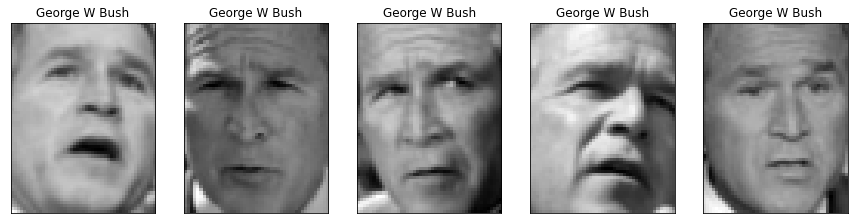

In [92]:
data = dataset.data
labels = dataset['target']

n_features = data.shape[1]


print_images = 5
images = dataset['images'][:print_images]
name = [dataset['target_names'][i] for i in labels[:print_images]]

visualize_n_w_labels(images, name)

**1.3** Divide the dataset into train and test set (0.7/0.3). 

**Hint:** use the train_test_split function.

In [93]:
# Split dataset into training and test
from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3)

X_train, X_test, y_train, y_test
print(X_train.shape)
print(X_test.shape)

(536, 2914)
(230, 2914)


### 2. Compute PCA

[*class sklearn.decomposition.PCA(n_components=None, copy=True, whiten=False, svd_solver='auto', tol=0.0, iterated_power='auto', random_state=None)*](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html?highlight=pca#sklearn.decomposition.PCA)

The principal components measure deviations about this mean along orthogonal axes.


**2.1** Create a PCA object, using the training set and a 150 components

In [94]:
# Principal component analysis
from sklearn.decomposition import PCA

n_comp=150

pca = PCA(n_components=n_comp, copy=True, whiten=False, svd_solver='auto', tol=0.0, iterated_power='auto', 
            random_state=None)

vector = pca.fit(X_train, y_train)

Plot the accumated variance of the components. 

**Hint:** Use the returned `explained_variance_ratio_`.

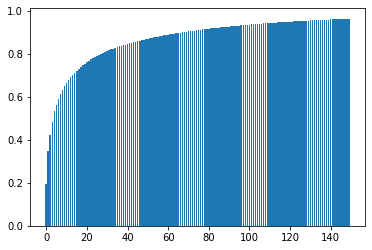

In [95]:
num_comp = [i for i in range(len(vector.explained_variance_ratio_))]
plt.bar(num_comp, np.cumsum(vector.explained_variance_ratio_))
plt.show()

What is the variable *pca*?

**ANSWER**

To understand what is PCA we just have to look at its initials: Principal component analysis.

The fucntion PCA creates an "object" to be filled with data (we will feed them the LFW dataset later) which will represent the most important components of the image. That is, reducing the dimensions of the problem minimizing the loss of generality.

Therefore, the code contains 639 (n_samples) vectors of length 150 which are the most important components to define the image.

**2.2** One interesting part of PCA is that it computes the average face, which can be interesting to examine. 

Plot the average face, using the method `mean_` of the PCA object.

**Hint:** The average face need to be reshaped in order to visualize it properly

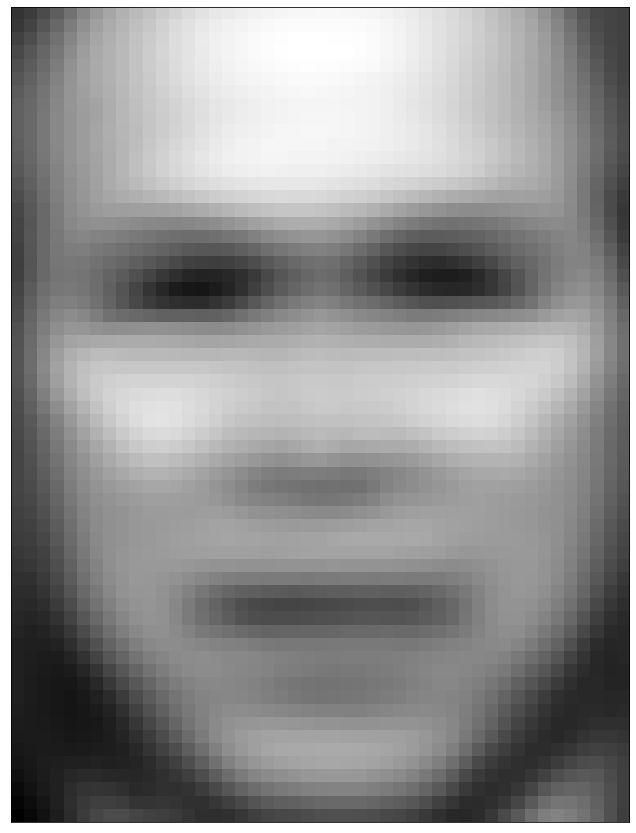

In [96]:
image = vector.mean_.reshape((height, width))

visualize_n([image])

**2.3** Furhtermore, we can check all the principal components (i.e. eigenfaces) considering the corresponding importance.

Visualize 30 principal eigenfaces

<img src="notebook_images/eigenfaces.png" width=500, height=500>

**ANSWER**

As it's seen in our answer, some pictures are the inverse (all the components times -1) because the principal components of an image are the eigenvectors of the initial image. And, we know a matrix $I$ (our image) can be descomposed into

$I=\lambda A$

where $\lambda$ is an escalar and A is our eigenvectors matrix. The equation is true in our case for $-1$ and $1$, therefore some images are inverted do to this fact.

150

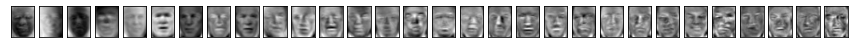

In [97]:
eigenvectors = [image.reshape((height, width)) for image in vector.components_]

visualize_n(eigenvectors[:30])
len(eigenvectors)

Note that the base components are ordered by their importance. We see that the first few components seem to primarily take care of lighting conditions; the remaining components pull out certain identifying features: the nose, eyes, eyebrows, etc.

**2.4** Project both the training and test set onto the PCA basis, using the method `transform()` of the PCA object.

In [98]:
trans_train = pca.transform(X_train)
trans_test = pca.transform(X_test)

Do you need to apply the same to the variable y?

**ANSWER**

No. The PCA algorithm does not change our number of samples (639), just reduces it's dimension cleverly to 150 components; therefore, the labels must not be changed.

**2.5**  These projected components correspond to factors in a linear combination of component images such that the combination approaches the original face. 

Choose one of the images and try to recompose from its first 10 most important corresponding eigenfaces.


<br/>
<img src="notebook_images/eigenfaces_image.PNG" width=300, height=300>


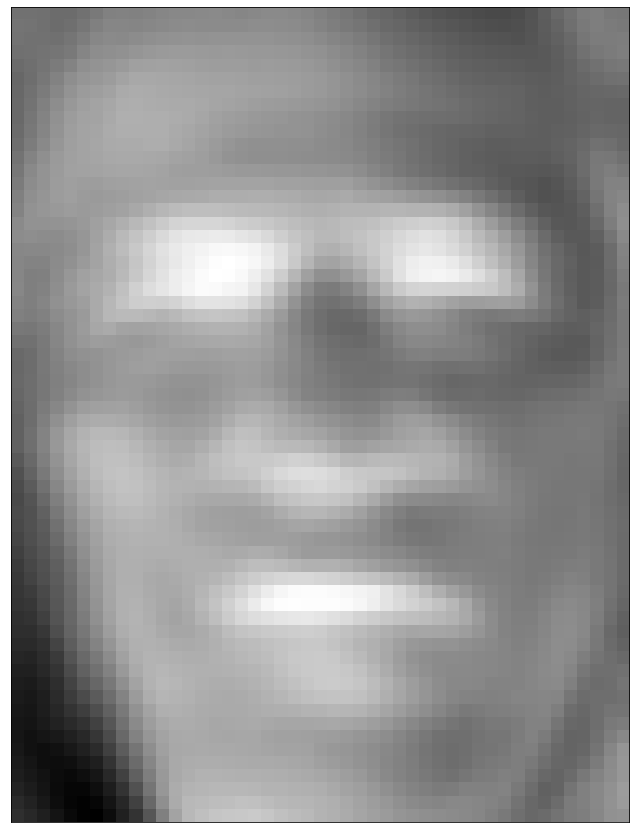

In [99]:
MOST_IMPORTANT = 10

eigenvalues = trans_train[0]

average = np.sum(np.array([eigenvalues[i]*eigenvectors[i] for i in range(0, MOST_IMPORTANT)]),axis=0)

visualize_n([average])

What is the purpose of the PCA tool?

**ANSWER**

As we have stated before, reduce the dimensions of our problems while minimizing the loss of generality to have a much more simple problem and faster (as we will see below) than training a neural network or other approaches.

### 3. Train a classifier

**3.1** Train an Adaboost classifier using the PCA features. Show the results obtained with the test set.
Use the `score` method of the Adaboost model.

In [100]:
# Train a Adaboost classifier
from sklearn.ensemble import AdaBoostClassifier

start = timeit.default_timer()

ada = AdaBoostClassifier(n_estimators=n_comp, learning_rate=1.0)
ada.fit(trans_train, y_train)

stop = timeit.default_timer()

timePCA=stop-start

timePCA

1.7496526919994722

In [101]:
ada.score(trans_test, y_test)

0.8913043478260869

**3.2** We can quantify this effectiveness using one of several measures from sklearn.metrics. First we can do the classification report, which shows the precision, recall and other measures of the “goodness” of the classification.

*sklearn.metrics.classification_report(y_true, y_pred, labels=None, target_names=None, sample_weight=None, digits=2, output_dict=False, zero_division='warn')*

*Please, check the parameters and returned value by ``classification_report()`` before continuing.*

Print the classification report obtained during the training of the Adaboost model.

In [102]:
# Classification and results
from sklearn.metrics import classification_report 

y_pred = ada.predict(trans_test)

result = classification_report(y_test, y_pred, labels=None, target_names=None, sample_weight=None, digits=2, 
                               output_dict=False, zero_division='warn')
print(result)

              precision    recall  f1-score   support

           0       0.79      0.83      0.81        65
           1       0.93      0.92      0.92       165

    accuracy                           0.89       230
   macro avg       0.86      0.87      0.87       230
weighted avg       0.89      0.89      0.89       230



Please, explaing what is:
- accuracy (score)
- precision
- recall
- f1-score
- support
- macro avg
- weighted avg


**ANSWER**

- _Accuracy_: how close the obtained value is to the real result.
- _Precision_: number of guesses of a class divided by the number of the elements of that class. Or mathematically: $tp /(tp + fp)$ where tp is true positives and fp false positives.
- _Recall_: how good is our classifier to find all the positive samples. Or, mathermatically: $tp/(tp + fn)$ where tp is the number of true positives and fn false negatives
- _F1-score_: the weigthed harmonic mean of the precision and recall and it's determined by a beta parameter.
- _Support_: number of occurrences of each class in y_true.
- _Macro avg_: the average unweigthed mean per label.
- _Weighted avg_: the average of the support-weighted mean per label


**3.3** Train an Adaboost classifier, without PCA, using the training set. Show the results using the `score` method of the Adaboost model and the corresponding classification report.

In [103]:
from sklearn.ensemble import AdaBoostClassifier

start = timeit.default_timer()

ada2 = AdaBoostClassifier(n_estimators=150)
ada2.fit(X_train, y_train)

stop = timeit.default_timer()

timeADA=stop-start

timeADA

17.758942745999775

In [104]:
ada2.score(X_test, y_test)

0.9260869565217391

**Questions**

- Does computing time change using PCA? How?
- Which of both (with and without PCA) does give better results?
- How does the result change if we change the number of components in PCA?
- How does the result change if we change the number of estimators in the Adaboost?

**ANSWER**

- Yes, it changes by a lot due the enourmous reduction of complexity of the problem. In one of our executions, PCA time was 1.094 and Adaboost was 14.702, fourteen times slower.
- The results are also better with PCA. On average we get between a 0.93-0.945 score in Adaboost. Meanwhile, PCA gives os  0.96-0.98 which is much better.
- Scores increase when number of estimators is incresed. But at some point (for more than 200) score starts decreasing, as we overfit train set.
- When the number of estimators decrease we have lower score. When we use more than 150 estimators results don't get much better. We supose that for more estimators, those are overfitting the train model.

**3.5 (Optional)** Repeat the experiment using a different number of components. 

For instance, instead of using 150 components, try using 10, 25, 50, 200, 500... at your election. These numbers are just orientative. 

- How much variance is acummulated using the different number of components.
- The result is better using... how many components? 
- Does time change using a different numbero of components?

In [105]:
results = {}

In [106]:
n_comp = 10
pca_t = PCA(n_components=n_comp, copy=True, whiten=False, svd_solver='auto', tol=0.0, iterated_power='auto', 
            random_state=None)

pca_t.fit(X_train, y_train)

trans_train = pca_t.transform(X_train)
trans_test = pca_t.transform(X_test)

start = timeit.default_timer()

ada_t = AdaBoostClassifier(n_estimators=n_comp, learning_rate=1.0)
ada_t.fit(trans_train, y_train)

stop = timeit.default_timer()

timePCA=stop-start



results[n_comp] = (timePCA, ada_t.score(trans_test, y_test, ), np.sum(pca_t.explained_variance_ratio_))

In [107]:
n_comp = 50
pca_t = PCA(n_components=n_comp, copy=True, whiten=False, svd_solver='auto', tol=0.0, iterated_power='auto', 
            random_state=None)

pca_t.fit(X_train, y_train)

trans_train = pca_t.transform(X_train)
trans_test = pca_t.transform(X_test)

start = timeit.default_timer()

ada_t = AdaBoostClassifier(n_estimators=n_comp, learning_rate=1.0)
ada_t.fit(trans_train, y_train)

stop = timeit.default_timer()

timePCA=stop-start

results[n_comp] = (timePCA, ada_t.score(trans_test, y_test, ), np.sum(pca_t.explained_variance_ratio_))

In [108]:
n_comp = 200
pca_t = PCA(n_components=n_comp, copy=True, whiten=False, svd_solver='auto', tol=0.0, iterated_power='auto', 
            random_state=None)

pca_t.fit(X_train, y_train)

trans_train = pca_t.transform(X_train)
trans_test = pca_t.transform(X_test)

start = timeit.default_timer()

ada_t = AdaBoostClassifier(n_estimators=n_comp, learning_rate=1.0)
ada_t.fit(trans_train, y_train)

stop = timeit.default_timer()

timePCA=stop-start

results[n_comp] = (timePCA, ada_t.score(trans_test, y_test, ), np.sum(pca_t.explained_variance_ratio_))

In [109]:
n_comp = 500
pca_t = PCA(n_components=n_comp, copy=True, whiten=False, svd_solver='auto', tol=0.0, iterated_power='auto', 
            random_state=None)

pca_t.fit(X_train, y_train)

trans_train = pca_t.transform(X_train)
trans_test = pca_t.transform(X_test)

start = timeit.default_timer()

ada_t = AdaBoostClassifier(n_estimators=n_comp, learning_rate=1.0)
ada_t.fit(trans_train, y_train)

stop = timeit.default_timer()

timePCA=stop-start

results[n_comp] = (timePCA, ada_t.score(trans_test, y_test, ), np.sum(pca_t.explained_variance_ratio_))

In [110]:
for comp in results.keys():
    print("Components: ", comp, "\t Time: ", round(results[comp][0], 3), "\t Score: ", results[comp][1], "\tVariance: ", results[comp][2])

Components:  10 	 Time:  0.013 	 Score:  0.782608695652174 	Variance:  0.64889485
Components:  50 	 Time:  0.15 	 Score:  0.8956521739130435 	Variance:  0.8678577
Components:  200 	 Time:  1.863 	 Score:  0.9173913043478261 	Variance:  0.9779233
Components:  500 	 Time:  10.889 	 Score:  0.9130434782608695 	Variance:  0.9996855


 - If we use more components varience increases.
 - Performance is better as we increase the number of components but it doesn't change so much when we take a lot of components.
 - Time increases as we use more components.

### 4. Recognize a new face example using the learned model

**4.1** Try your both models using the test set. 

Predict the labels using the Adaboost model, with and without PCA, and plot the images with the corresponding label as title.

<img src="notebook_images/prediction.png" width=300 height = 300>

In [111]:
def label(predicted, expected):
    return "P: " + dataset['target_names'][predicted] + "\nE: " + dataset['target_names'][expected]

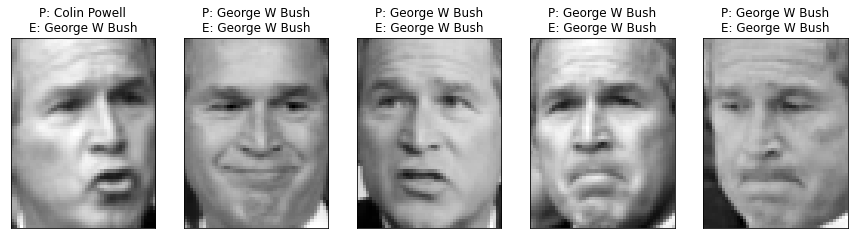

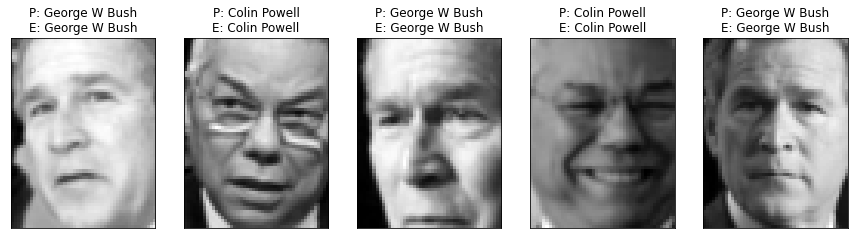

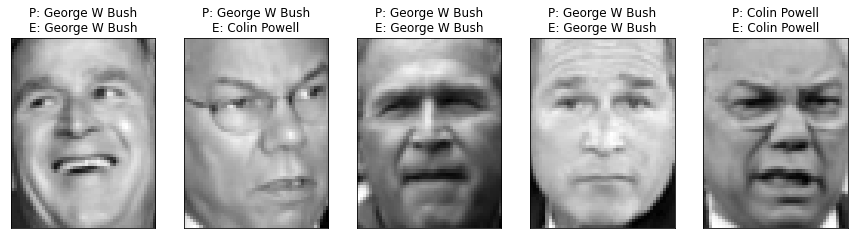

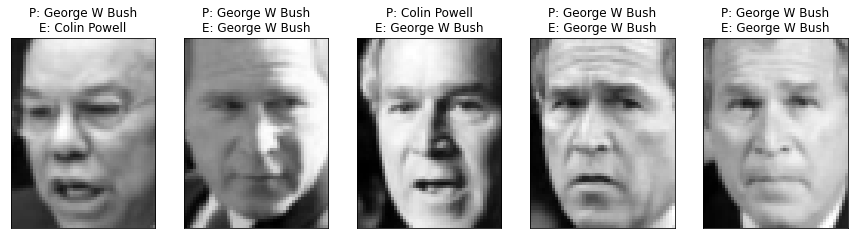

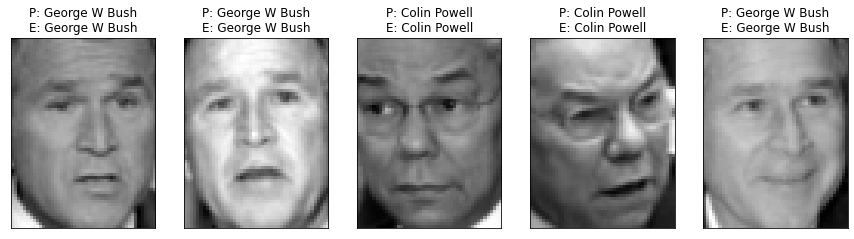

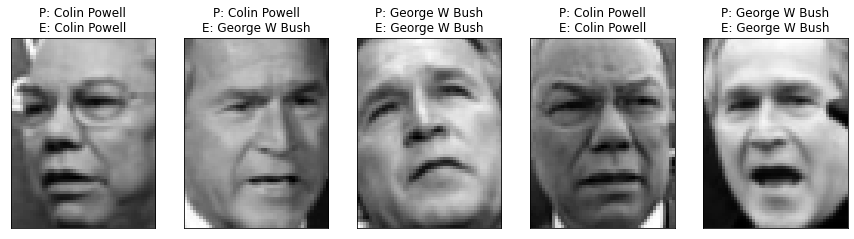

In [112]:
#With PCA
trans_test = pca.transform(X_test)

prediction = ada.predict(trans_test)
labels = [label(prediction[i], y_test[i]) for i in range(len(prediction))]

images = [image.reshape(height, width) for image in X_test]

visualize_n_w_labels(images[:5], labels[:5])
visualize_n_w_labels(images[5:10], labels[5:10])
visualize_n_w_labels(images[10:15], labels[10:15])
visualize_n_w_labels(images[15:20], labels[15:20])
visualize_n_w_labels(images[20:25], labels[20:25])
visualize_n_w_labels(images[25:30], labels[25:30])

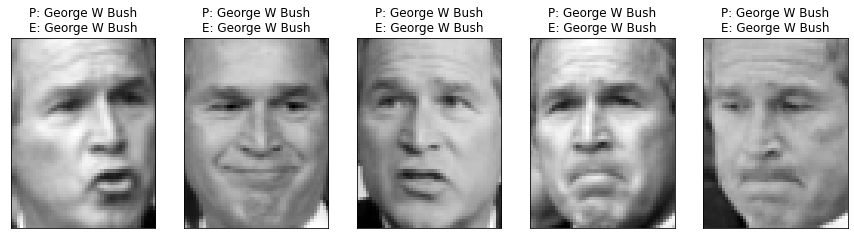

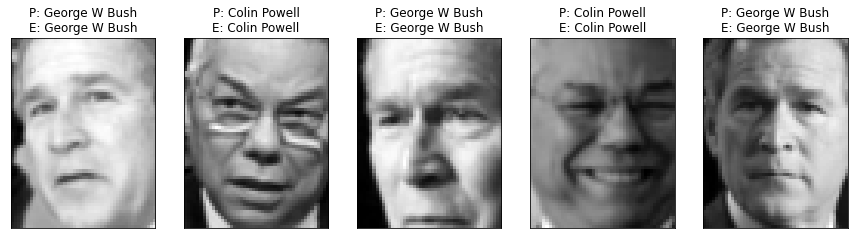

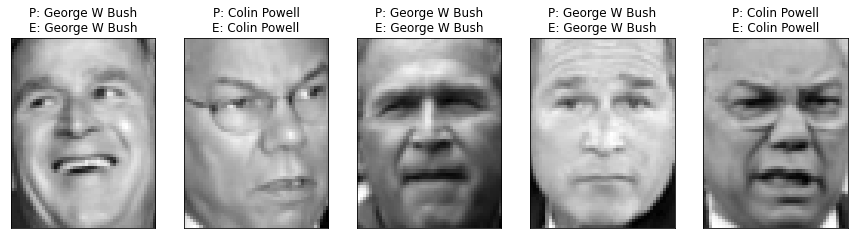

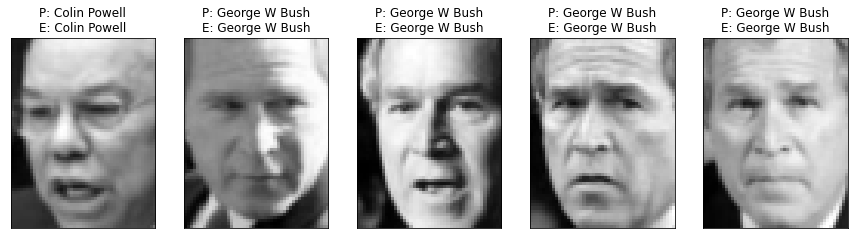

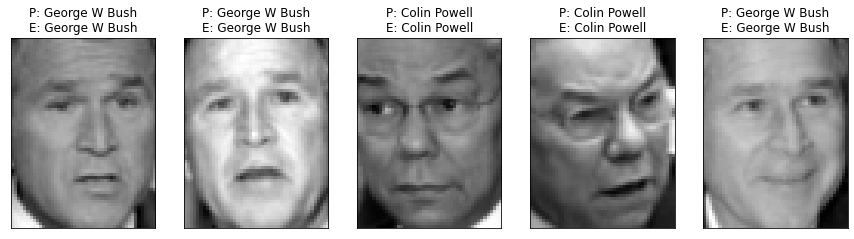

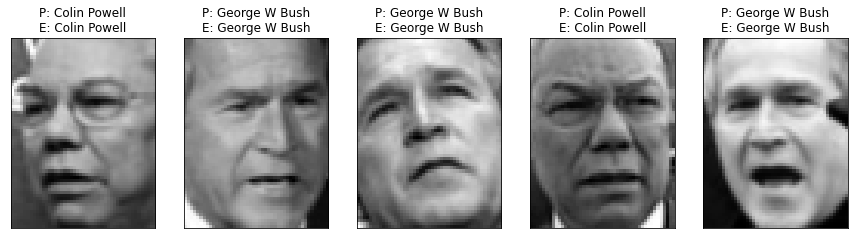

In [113]:
#Without PCA

prediction = ada2.predict(X_test)
labels = [label(prediction[i], y_test[i]) for i in range(len(prediction))]

images = [image.reshape(height, width) for image in X_test]

visualize_n_w_labels(images[:5], labels[:5])
visualize_n_w_labels(images[5:10], labels[5:10])
visualize_n_w_labels(images[10:15], labels[10:15])
visualize_n_w_labels(images[15:20], labels[15:20])
visualize_n_w_labels(images[20:25], labels[20:25])
visualize_n_w_labels(images[25:30], labels[25:30])

Which model makes the predictions betters? Try different parameters.

As we have seen in scores, the model with PCA has better prediction rate.